# Change the runtime type from CPU to T4 GPU to get in less time.

# 📦 STEP 1: Install dependencies

In [1]:
!pip install bm3d torch torchvision matplotlib scikit-image

# 🧱 STEP 2: Clone SwinIR repo (contains required model architecture and weights)

In [2]:
!git clone https://github.com/JingyunLiang/SwinIR.git
%cd SwinIR
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/004_grayDN_DFWB_s128w8_SwinIR-M_noise25.pth -P model_zoo/swinir
%cd ..

fatal: destination path 'SwinIR' already exists and is not an empty directory.
/content/SwinIR
--2025-07-30 10:50:59--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/004_grayDN_DFWB_s128w8_SwinIR-M_noise25.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/396770997/b7cffcd7-199d-4589-b01f-f4b41c1c1833?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-30T11%3A32%3A10Z&rscd=attachment%3B+filename%3D004_grayDN_DFWB_s128w8_SwinIR-M_noise25.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-30T10%3A31%3A59Z&ske=2025-07-30T11%3A32%3A10Z&sks=b&skv=2018-11-09&sig=xtJLFP6ic4b4mXW7nUX6NbOPxZ%2BJwhOpoChMC306xac%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWF

# 📤 STEP 3: Upload your original image

In [3]:
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()
image_path = list(uploaded.keys())[0]
u = np.array(Image.open(image_path).convert('L'), dtype=np.float32)/255.

Saving ultra.jpg to ultra.jpg


# 🔘 STEP 4: Select noise level using slider

In [4]:
import ipywidgets as widgets
from IPython.display import display

noise_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Noise Level (L)')
display(noise_slider)


IntSlider(value=1, description='Noise Level (L)', max=10, min=1)

# 💥 STEP 5: Define denoising functions

In [8]:
import os, sys
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.special import gamma
from skimage.metrics import structural_similarity
from torchvision.transforms import ToTensor

def psnr(u, u0):
    I, J = u.shape
    diff = u - u0
    l2_squared = np.sum(diff ** 2)
    dynamic_range_sq = (np.max(u0) - np.min(u0)) ** 2
    return 10 * np.log10(dynamic_range_sq * I * J / l2_squared)

def compute_gradients(u):
    gradN = np.roll(u, -1, 0) - u
    gradS = np.roll(u, 1, 0) - u
    gradE = np.roll(u, -1, 1) - u
    gradW = np.roll(u, 1, 1) - u
    return gradN, gradS, gradE, gradW

def diffusion_coefficient(grad_dir_Gu, grad_dir_ut, v, lam, beta):
    return 1.0 / (1 + v * lam * np.abs(grad_dir_Gu)**beta + v * (1-lam) * np.abs(grad_dir_ut)**beta)

def ip_nde_denoising(f, u_tilde, alpha=1.3, beta=1.4, lam=0.1, v=1.0, sigma=0.9, T=20, tau=0.2, beta_c=0.95):
    u_hist = [f.copy(), f.copy()]
    b = [1.0] + [((k+1)**(1-beta_c) - k**(1-beta_c)) for k in range(1, T+1)]
    b0, g = b[0], gamma(2-beta_c)
    u = f.copy()
    for n in range(1, T+1):
        u_prev = u_hist[-1]
        Gun = gaussian_filter(u_prev, sigma=sigma)
        a = np.clip(Gun / (np.max(Gun)+1e-8), 1e-8, None)**alpha
        gradN_u, gradS_u, gradE_u, gradW_u = compute_gradients(u_prev)
        gradN_Gu, gradS_Gu, gradE_Gu, gradW_Gu = compute_gradients(Gun)
        gradN_ut, gradS_ut, gradE_ut, gradW_ut = compute_gradients(u_tilde)
        CN = diffusion_coefficient(gradN_Gu, gradN_ut, v, lam, beta)
        CS = diffusion_coefficient(gradS_Gu, gradS_ut, v, lam, beta)
        CE = diffusion_coefficient(gradE_Gu, gradE_ut, v, lam, beta)
        CW = diffusion_coefficient(gradW_Gu, gradW_ut, v, lam, beta)
        div = CN*gradN_u + CS*gradS_u + CE*gradE_u + CW*gradW_u
        frac_sum = np.zeros_like(u)
        for s in range(1, min(n, len(b))):
            u_n1s = u_hist[-s]
            u_ns  = u_hist[-(s+1)]
            frac_sum += b[s]*(u_n1s - u_ns)
        u_next = u_prev - (1/b0)*(frac_sum - (tau**beta_c)*div*g)
        u_next[0,:], u_next[-1,:] = u_next[1,:], u_next[-2,:]
        u_next[:,0], u_next[:,-1] = u_next[:,1], u_next[:,-2]
        u_hist.append(u_next)
        u = u_next
    return u

class DIPNet(nn.Module):
    def __init__(self, input_channels=32, output_channels=1, features=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, features, 3, padding=1), nn.ReLU(),
            nn.Conv2d(features, features, 3, padding=1), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(features, features, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(features, features, 3, padding=1), nn.ReLU(),
            nn.Conv2d(features, output_channels, 3, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.middle(self.encoder(x)))

def get_dip_prior(f, num_iter=100, lr=1e-3, depth=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = DIPNet(input_channels=depth).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    noise = torch.randn(1, depth, *f.shape, device=device)
    target = torch.tensor(f[None, None], dtype=torch.float32, device=device)
    best = None; best_loss = 1e9
    for _ in range(num_iter):
        opt.zero_grad()
        out = net(noise)
        loss = nn.functional.mse_loss(out, target)
        loss.backward(); opt.step()
        if loss.item() < best_loss:
            best_loss = loss.item(); best = out.detach()
    return best.squeeze().cpu().numpy()

def load_swinir_model():
    swinir_path = os.path.abspath("SwinIR")
    if swinir_path not in sys.path:
        sys.path.append(swinir_path)
    from models.network_swinir import SwinIR as net
    model = net(
        upscale=1,
        in_chans=1,
        img_size=128,
        window_size=8,
        img_range=1.0,
        depths=[6, 6, 6, 6, 6, 6],
        embed_dim=180,
        num_heads=[6, 6, 6, 6, 6, 6],
        mlp_ratio=2,
        upsampler='',
        resi_connection='1conv'
    )
    ckpt_path = os.path.join(swinir_path, 'model_zoo/swinir/004_grayDN_DFWB_s128w8_SwinIR-M_noise25.pth')
    state = torch.load(ckpt_path, map_location='cpu')
    if 'params' in state:
        state = state['params']
    model.load_state_dict(state, strict=True)
    model.eval()
    return model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

def get_swinir_prior(f, model):
    img = ToTensor()(f).unsqueeze(0).to(next(model.parameters()).device)
    img = img.float()
    with torch.no_grad():
        out = model(img)
    return out.squeeze().cpu().numpy()

def add_gamma_speckle_noise(u, L=1):
    eta = np.random.gamma(shape=L, scale=1.0 / L, size=u.shape)
    return u * eta


# 🎯 STEP 6: Run IP-NFDE + DIP and IP-NFDE + SwinIR

In [9]:
L = noise_slider.value
print(f"Adding Gamma Speckle Noise with L = {L} ...")
f = add_gamma_speckle_noise(u, L=L)

print("Running DIP...")
u_tilde_dip = get_dip_prior(f)

print("Loading SwinIR...")
swin_model = load_swinir_model()
print("Running SwinIR...")
u_tilde_swin = get_swinir_prior(f, swin_model)

params = dict(alpha=1.3, beta=1.4, lam=0.1, sigma=0.9, v=1.0, T=20, tau=0.2)
print("Denoising with IP-NFDE + DIP...")
out_dip = ip_nde_denoising(f, u_tilde_dip, **params)
print("Denoising with IP-NFDE + SwinIR...")
out_swin = ip_nde_denoising(f, u_tilde_swin, **params)

Adding Gamma Speckle Noise with L = 5 ...
Running DIP...
Loading SwinIR...
Running SwinIR...
Denoising with IP-NDE + DIP...
Denoising with IP-NDE + SwinIR...


# 📊 STEP 7: Visualize


|       Method      | PSNR  |  SSIM  |
|-------------------|-------|--------|
|       Noisy       | 17.87 | 0.6140 |
|   IP-NFDE + DIP   | 29.32 | 0.8230 |
|  IP-NFDE + SwinIR | 29.54 | 0.8252 |


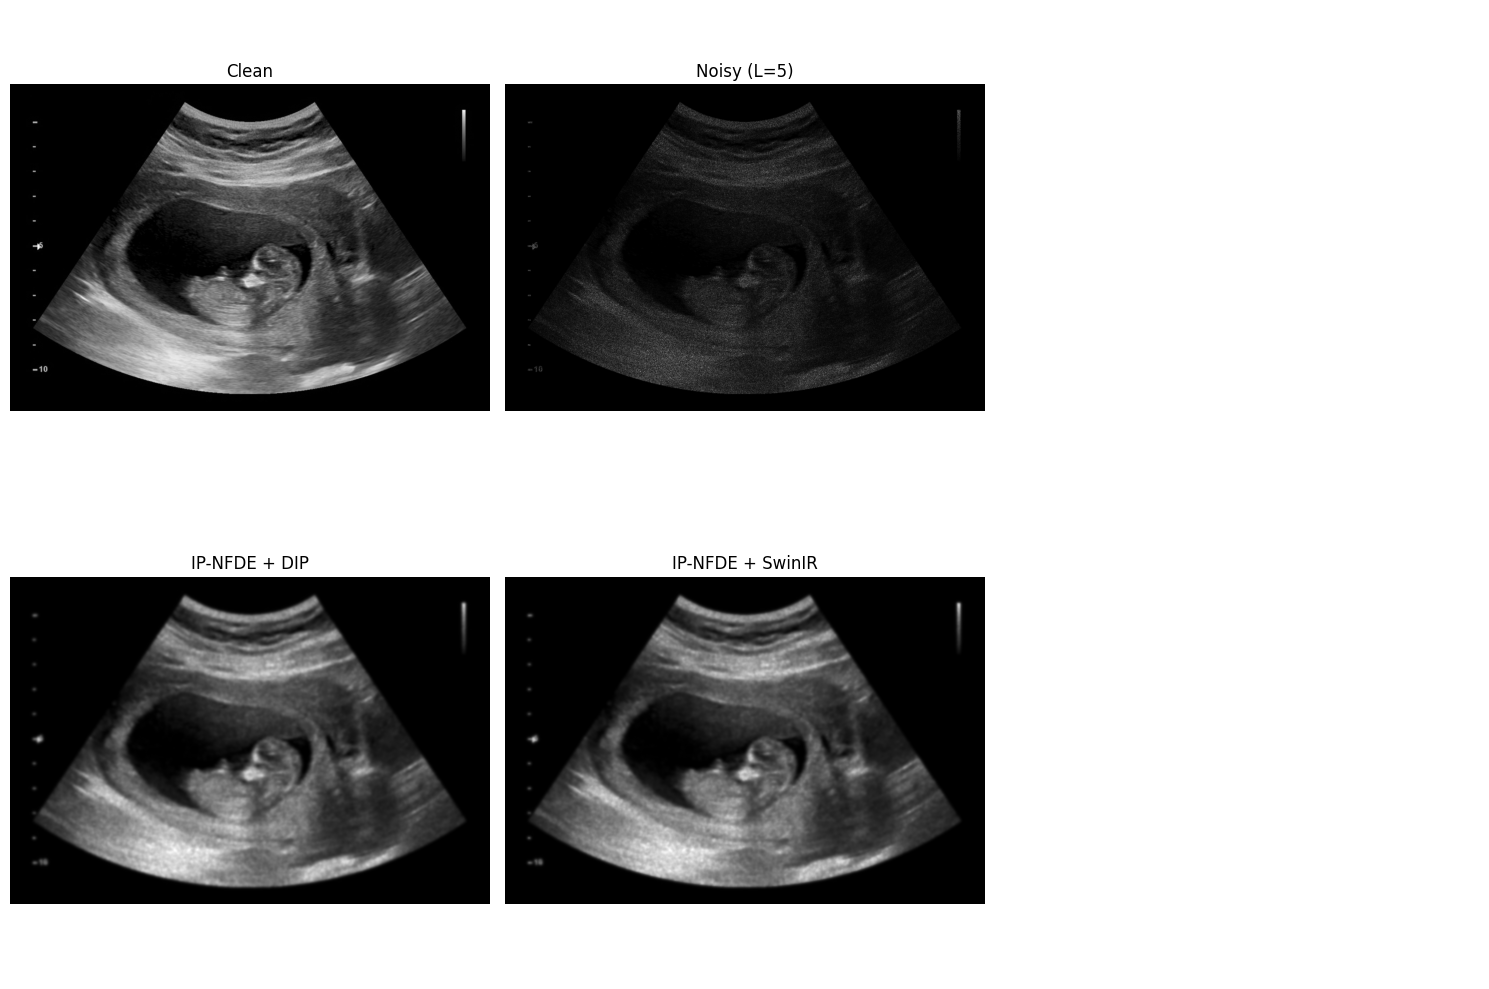

In [21]:
from skimage.metrics import structural_similarity as ssim
print("\n|       Method      | PSNR  |  SSIM  |")
print("|-------------------|-------|--------|")
print(f"|       Noisy       | {psnr(f, u):.2f} | {ssim(u, f, data_range=1.0):.4f} |")
print(f"|   IP-NFDE + DIP   | {psnr(out_dip, u):.2f} | {ssim(u, out_dip, data_range=1.0):.4f} |")
print(f"|  IP-NFDE + SwinIR | {psnr(out_swin, u):.2f} | {ssim(u, out_swin, data_range=1.0):.4f} |")

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0,0].imshow(u, cmap='gray'); axs[0,0].set_title("Clean")
axs[0,1].imshow(f, cmap='gray'); axs[0,1].set_title(f"Noisy (L={L})")
axs[0,2].axis('off')
axs[1,0].imshow(out_dip, cmap='gray'); axs[1,0].set_title("IP-NFDE + DIP")
axs[1,1].imshow(out_swin, cmap='gray'); axs[1,1].set_title("IP-NFDE + SwinIR")
axs[1,2].axis('off')
for ax in axs.flatten(): ax.axis('off')
plt.tight_layout(); plt.show()